# Laboratorium 5. (Singular Value Decomposition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from skimage import data, color
from skimage.transform import resize
from numpy.linalg import norm

## 1. Przekształcenie sfery w elipsoidę

### 1.1. Generowanie i transformacja sfery jednostkowej

In [2]:
def create_unit_sphere(resolution=30):
    s = np.linspace(0, 2*np.pi, resolution)
    t = np.linspace(0, np.pi, resolution)

    s_grid, t_grid = np.meshgrid(s, t)

    x = np.cos(s_grid) * np.sin(t_grid)
    y = np.sin(s_grid) * np.sin(t_grid)
    z = np.cos(t_grid)

    points = np.vstack([x.flatten(), y.flatten(), z.flatten()]).T

    return points, x, y, z


def transform_sphere(points, A):
    return points @ A.T

### 1.2. Funkcje odpowiadające za wizualizację transformacji oraz poszczególnych kroków metody SVD

In [3]:
def plot_ellipsoid(sphere_coords, transformed_points, singular_values, V, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, _, _ = sphere_coords
    points_transformed = transformed_points.reshape(x.shape[0], x.shape[1], 3)

    ax.plot_surface(points_transformed[:,:,0], points_transformed[:,:,1], points_transformed[:,:,2],
                   color='b', alpha=0.3)

    origin = np.zeros(3)

    for i in range(3):
        axis = singular_values[i] * V.T[i]
        ax.quiver(origin[0], origin[1], origin[2],
                 axis[0], axis[1], axis[2],
                 color=['r', 'g', 'y'][i], linewidth=3, arrow_length_ratio=0.1,
                 label=f'Semi-axis {i+1}: {singular_values[i]:.2f}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    max_val = np.max(np.abs(transformed_points)) * 1.2
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    ax.set_zlim(-max_val, max_val)

    ax.legend()

    return fig, ax


def visualize_svd_steps(sphere_points, A, sigma, VT, title):
    fig = plt.figure(figsize=(18, 6))

    # SV^T
    ax1 = fig.add_subplot(131, projection='3d')
    sv_points = sphere_points @ VT.T
    sv_points_matrix = sv_points.reshape(30, 30, 3)
    ax1.plot_surface(sv_points_matrix[:,:,0],
                     sv_points_matrix[:,:,1],
                     sv_points_matrix[:,:,2], 
                     color='r',
                     alpha=0.3)
    ax1.set_title("SV^T")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # SΣV^T
    ax2 = fig.add_subplot(132, projection='3d')
    sigma_matrix = np.diag(sigma)
    ssigma_vt_points = sv_points @ sigma_matrix
    ssigma_vt_points_matrix = ssigma_vt_points.reshape(30, 30, 3)
    ax2.plot_surface(ssigma_vt_points_matrix[:,:,0],
                     ssigma_vt_points_matrix[:,:,1],
                     ssigma_vt_points_matrix[:,:,2],
                     color='g',
                     alpha=0.3)
    ax2.set_title("SΣV^T")
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    # SU^TΣV^T = SA
    ax3 = fig.add_subplot(133, projection='3d')
    transformed_points = sphere_points @ A.T
    transformed_points_matrix = transformed_points.reshape(30, 30, 3)
    ax3.plot_surface(transformed_points_matrix[:,:,0],
                     transformed_points_matrix[:,:,1],
                     transformed_points_matrix[:,:,2],
                     color='b',
                     alpha=0.3)
    ax3.set_title("SU^TΣV^T = SA")
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    max_val = np.max(np.abs(transformed_points)) * 1.2
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)
        ax.set_zlim(-max_val, max_val)

    plt.suptitle(title)
    plt.tight_layout()

    return fig

### 1.3. Wyniki

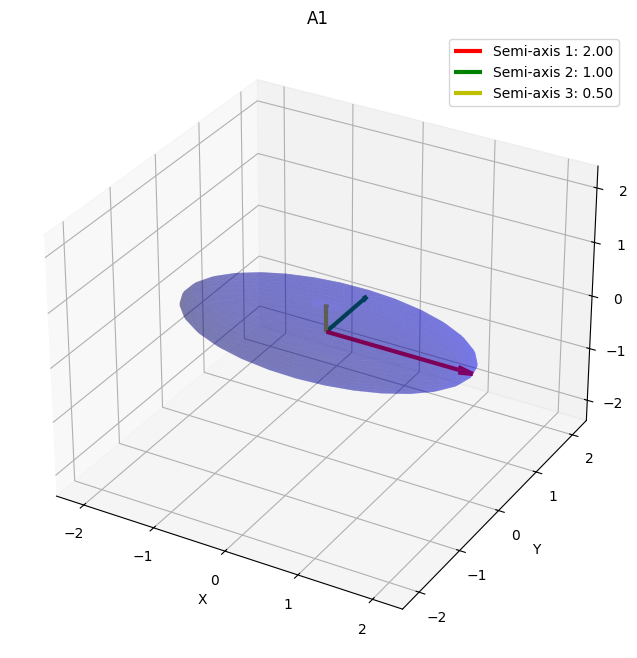

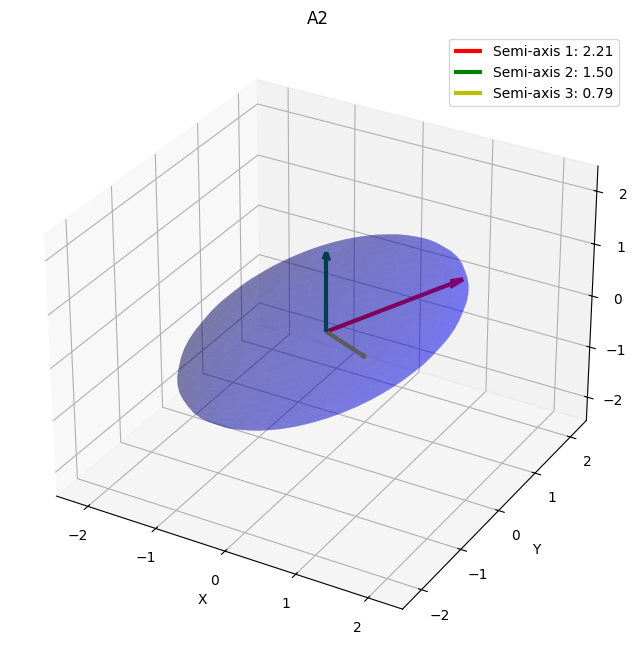

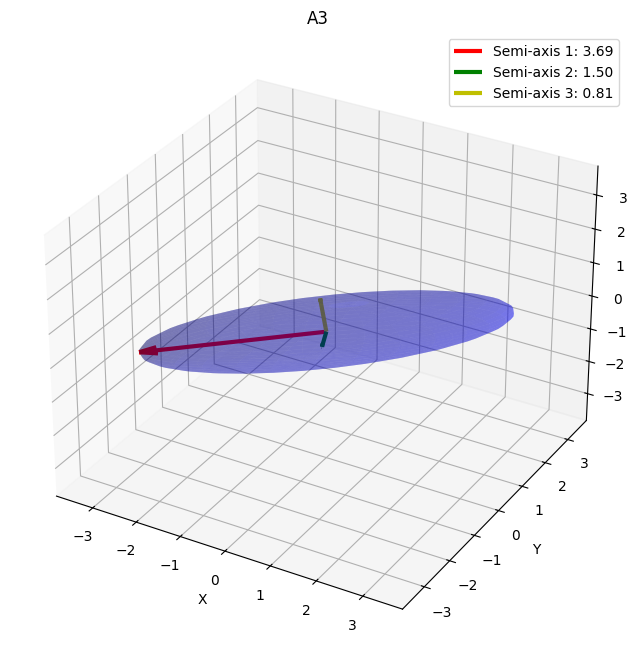

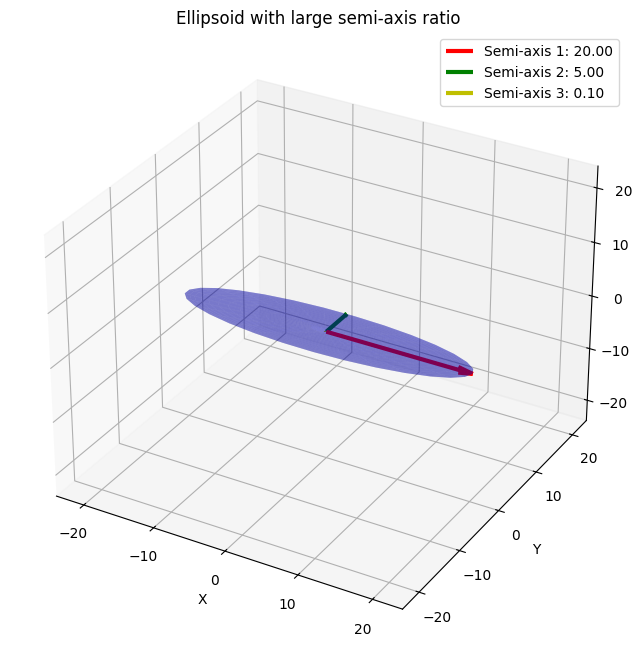

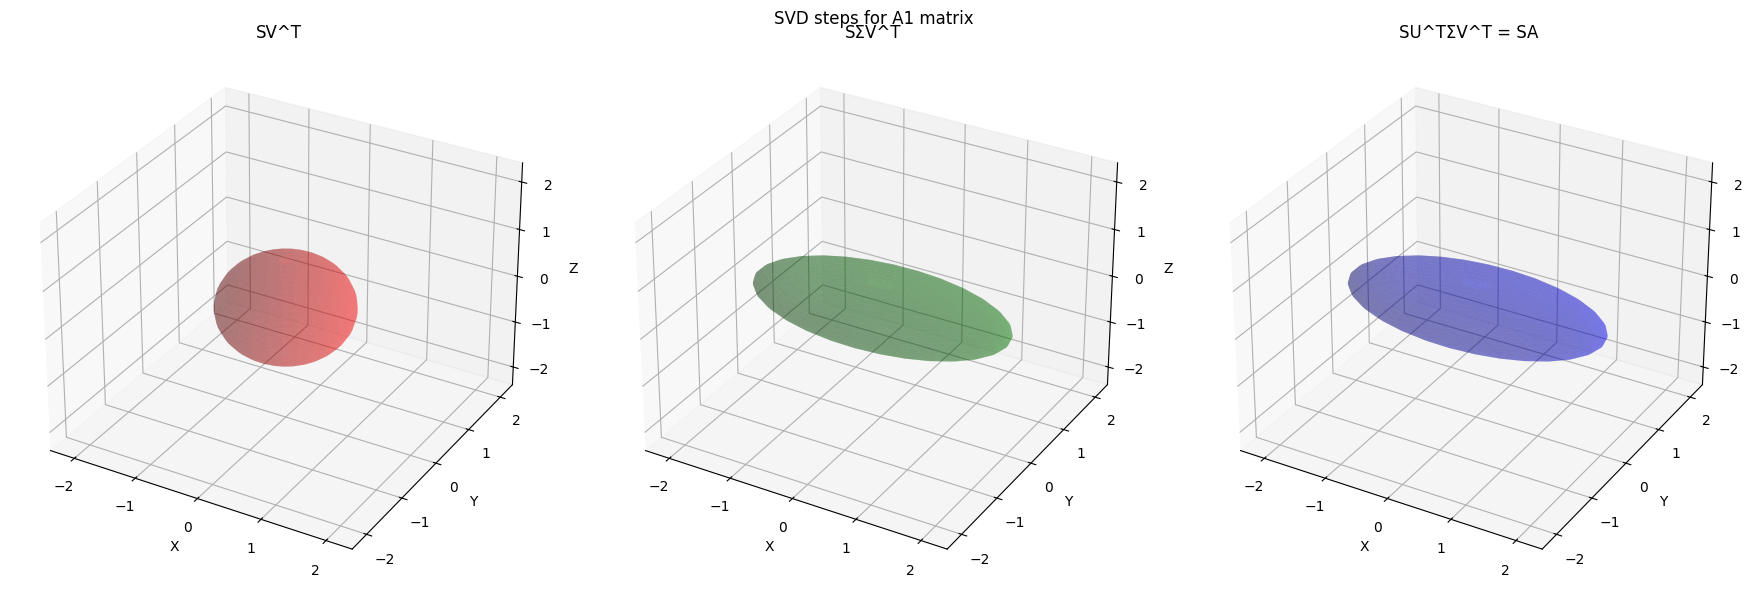

In [4]:
# 1. Create unit sphere
sphere_points, x_sphere, y_sphere, z_sphere = create_unit_sphere(resolution=30)
sphere_coords = (x_sphere, y_sphere, z_sphere)

# 2. Transformations
# A1: scaling
A1 = np.diag([2, 1, 0.5])

# A2: rotation + scaling
A2 = np.array([
    [1, 0.5, 0],
    [0.5, 2, 0],
    [0, 0, 1.5]
])

# A3: More complex transformation
A3 = np.array([
    [3, 1, 0.5],
    [1, 2, 0],
    [0.5, 0, 1]
])

transformed_points1 = transform_sphere(sphere_points, A1)
transformed_points2 = transform_sphere(sphere_points, A2)
transformed_points3 = transform_sphere(sphere_points, A3)
plt.show()

# 3. SVD
_, sigma1, VT1 = linalg.svd(A1)
_, sigma2, VT2 = linalg.svd(A2)
_, sigma3, VT3 = linalg.svd(A3)

plot_ellipsoid(sphere_coords, transformed_points1, sigma1, VT1.T, "A1")
plot_ellipsoid(sphere_coords, transformed_points2, sigma2, VT2.T, "A2")
plot_ellipsoid(sphere_coords, transformed_points3, sigma3, VT3.T, "A3")
plt.show()

# 4. Large semi-axis ratio
A4 = np.diag([20, 5, 0.1])

_, sigma4, V4 = linalg.svd(A4)

transformed_points4 = transform_sphere(sphere_points, A4)
plot_ellipsoid(sphere_coords, transformed_points4, sigma4, V4, "Ellipsoid with large semi-axis ratio")
plt.show()

# 5. SVD steps
visualize_svd_steps(sphere_points, A1, sigma1, VT1, "SVD steps for A1 matrix")
plt.show()

## 2. Kompresja obrazu

### 2.1. Implementacja kompresji obrazu z wykorzystaniem SVD

In [5]:
def compress_image(img, k_values):
    U, sigma, VT = linalg.svd(img)

    compressed_images = {}

    for k in k_values:
        sigma_k = np.zeros_like(img)
        np.fill_diagonal(sigma_k[:k, :k], sigma[:k])

        img_compressed = U @ sigma_k @ VT

        compressed_images[k] = img_compressed

    return compressed_images

### 2.2. Funkcje pomocnicze

In [6]:
def prepare_image():
    img = data.astronaut()
    img = img[50:550, 50:550]

    if len(img.shape) == 3:
        img = color.rgb2gray(img)

    img = resize(img, (512, 512), anti_aliasing=True)

    return img


def analyze_compression(img, k_values):
    original_size = img.shape[0] * img.shape[1]

    for k in k_values:
        compressed_size = k * (img.shape[0] + img.shape[1] + 1)
        compression_ratio = original_size / compressed_size
        print(f"k = {k}: Compression ratio = {compression_ratio:.2f}x")

### 2.3. Funkcje odpowiadające za wizualizację wyników

In [7]:
def compare_images(original_img, compressed_images, k_values):
    n = len(k_values)

    differences = {}
    norms = {}

    for k in k_values:
        differences[k] = original_img - compressed_images[k]
        norms[k] = norm(differences[k])

    _, axes = plt.subplots(2, n+1, figsize=(15, 8))

    axes[0, 0].imshow(original_img, cmap='gray')
    axes[0, 0].set_title('Original image')
    axes[0, 0].axis('off')

    axes[1, 0].axis('off')

    for i, k in enumerate(k_values):
        axes[0, i+1].imshow(compressed_images[k], cmap='gray')
        axes[0, i+1].set_title(f'k = {k}')
        axes[0, i+1].axis('off')

        axes[1, i+1].imshow(differences[k], cmap='gray')
        axes[1, i+1].set_title(f'||I-I_a|| = {norms[k]:.2f}')
        axes[1, i+1].axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, [norms[k] for k in k_values], 'o-')
    plt.title('||I-I_a|| vs. k')
    plt.xlabel('k (amount of singular values)')
    plt.ylabel('||I-I_a||')
    plt.grid(True)
    plt.show()

### 2.4. Wyniki

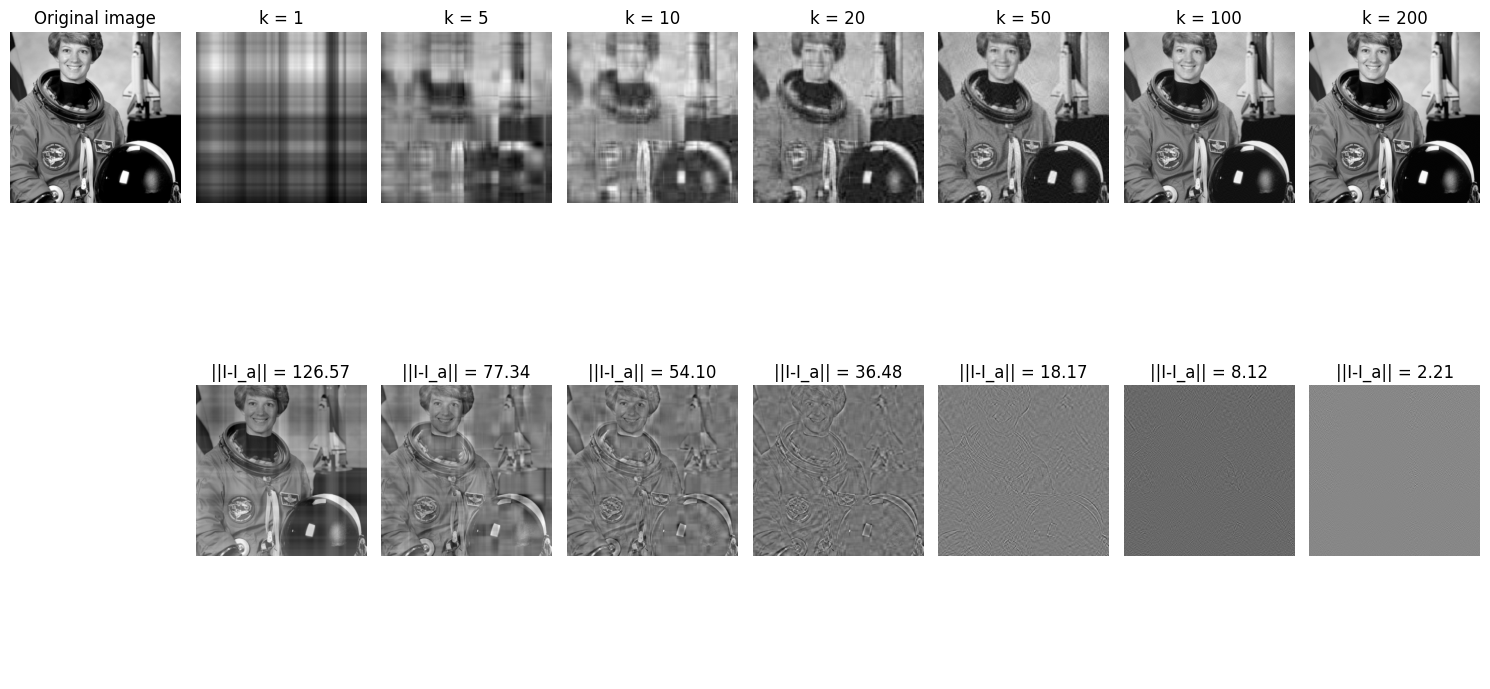

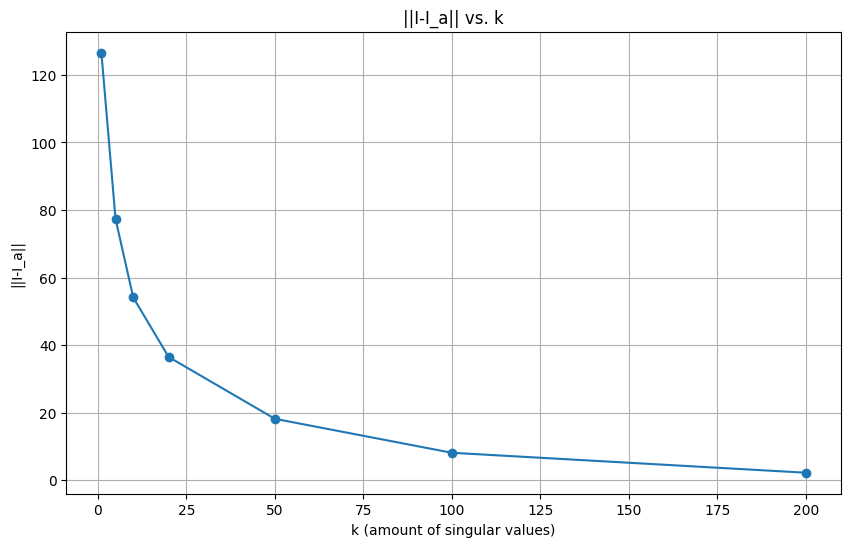

k = 1: Compression ratio = 255.75x
k = 5: Compression ratio = 51.15x
k = 10: Compression ratio = 25.58x
k = 20: Compression ratio = 12.79x
k = 50: Compression ratio = 5.12x
k = 100: Compression ratio = 2.56x
k = 200: Compression ratio = 1.28x


In [8]:
k_values = [1, 5, 10, 20, 50, 100, 200]

img = prepare_image()
compressed_images = compress_image(img, k_values)
compare_images(img, compressed_images, k_values)
analyze_compression(img, k_values)